# Two Phases, No Inoculation

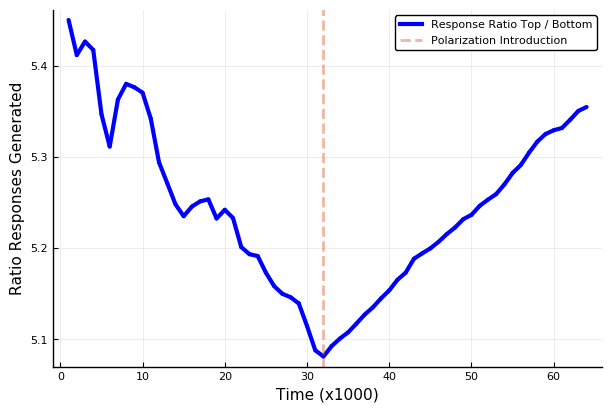

([5.45088; 5.41233; … ; 5.35097; 5.35529], [5.45088; 5.41233; … ; 5.35097; 5.35529])

In [3]:

using Random
using StatsPlots
using Plots
pyplot()

test_vector = zeros(40)


function basal_update(simulation_matrix, nodes, node, timestep, basal_rate)  
    if (rand(1)[1] <= basal_rate)
	test_vector[node] += 1
	tmp = deleteat!(collect(1:nodes), node)
        destination_n = tmp[rand(1:end)]
	simulation_matrix[node, destination_n, timestep] = 1
    end
end


function response_update_three_phase(simulation_matrix, importance, nodes, node, 
			 timesteps, timestep, response_recipients, 
			 importance_gain)

    # Loop for each node calculating response probability and performing
    # message propagation.

    mask_odd = [(-1)^x for x in 1:nodes]
    mask_even = [(-1)^(x+1) for x in 1:nodes]
    mask_odd_neutral = map(x -> rand(1)[1] > .5 ? x : 1, mask_odd)
    mask_even_neutral = map(x -> rand(1)[1] > .5 ? x : 1, mask_even)

    successful_messages_to_node = simulation_matrix[:, node, timestep-1]
    total_importance = 0

    # Check if any messages were sent
    if sum(successful_messages_to_node) > 0
	#print("Node = ", node, "\n")
	# Timesteps in phase 1
	if timestep <= timesteps/3
	    total_importance = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:nodes])
	# Timesteps in phase 2
	elseif timestep <= 2*timesteps/3
	    # Filter for odd and even group membership
	    if node % 2 == 0
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
				        mask_odd[x] for x in 1:nodes])
	    else
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
					mask_even[x] for x in 1:nodes])
	    end
	# Timesteps in phase 3
	else
	    # Filter for odd and even group membership
	    if node % 2 == 0
		
        total_importance_1 = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:Int32(floor(nodes/2))])
                
        total_importance_2 = sum([successful_messages_to_node[x] * importance[x] *
					mask_odd[x] for x in Int32(ceil(nodes/2)):nodes])
        total_importance = total_importance_1 + total_importance_2
	    
        else
		
        total_importance_1 = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:Int32(floor(nodes/2))])
                
        total_importance_2 = sum([successful_messages_to_node[x] * importance[x] *
					mask_even[x] for x in Int32(ceil(nodes/2)):nodes])
                
        total_importance = total_importance_1 + total_importance_2
        
        end
	end
    end

    # Response rate calculation
    response_numerator = total_importance
	
    response_denominator = 1 + findmax(importance)[1] * 
				sum(simulation_matrix[:, node, timestep-1])
	
    response_rate = response_numerator / response_denominator

    if total_importance != 0
	#print("Response Rate", response_rate, "\n")
    end

    # Pick response_recipients number of targets and send content with 
    # probability response_rate
    if response_rate > rand(1)[1]
	test_vector[node] += 4
	tmp = deleteat!(collect(1:nodes), node)
	destination_nodes = tmp[randperm(length(tmp))[1:response_recipients]]
	for dest_node in destination_nodes
	    simulation_matrix[node, dest_node, timestep] = 1
        end
	importance = (importance_gain * successful_messages_to_node) + importance
    else
        successful_messages_to_node = zeros(nodes,1)
    end

    return successful_messages_to_node, importance, simulation_matrix
end








function response_update_two_phase(simulation_matrix, importance, nodes, node, 
			 timesteps, timestep, response_recipients, 
			 importance_gain)

    # Loop for each node calculating response probability and performing
    # message propagation.

    mask_odd = [(-1)^x for x in 1:nodes]
    mask_even = [(-1)^(x+1) for x in 1:nodes]

    successful_messages_to_node = simulation_matrix[:, node, timestep-1]
    total_importance = 0

    # Check if any messages were sent
    if sum(successful_messages_to_node) > 0
	#print("Node = ", node, "\n")
	# Timesteps in phase 1
	if timestep <= timesteps/2
	    total_importance = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:nodes])
	# Timesteps in phase 2
	else
	    # Filter for odd and even group membership
	    if node % 2 == 0
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
				        mask_odd[x] for x in 1:nodes])
	    else
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
					mask_even[x] for x in 1:nodes])
	    end
	end
    end

    # Response rate calculation
    response_numerator = total_importance
	
    response_denominator = 1 + findmax(importance)[1] * 
				sum(simulation_matrix[:, node, timestep-1])
	
    response_rate = response_numerator / response_denominator

    if total_importance != 0
	#print("Response Rate", response_rate, "\n")
    end

    # Pick response_recipients number of targets and send content with 
    # probability response_rate
    if response_rate > rand(1)[1]
	test_vector[node] += 4
	tmp = deleteat!(collect(1:nodes), node)
	destination_nodes = tmp[randperm(length(tmp))[1:response_recipients]]
	for dest_node in destination_nodes
	    simulation_matrix[node, dest_node, timestep] = 1
        end
	importance = (importance_gain * successful_messages_to_node) + importance
    else
        successful_messages_to_node = zeros(nodes,1)
    end
    
    return successful_messages_to_node, importance, simulation_matrix
end




function capture_statistics(node, timesteps, timestep, messages_sent, 
			    responses_triggered, total_responses, three_phase)
    if three_phase
        # Gather total responses triggered grouped by phase (1,2,3)
        if timestep < timesteps/3
            responses_triggered[:, node, 1] = responses_triggered[:, node, 1] .+ 
					      messages_sent
        elseif timestep < 2*timesteps/3
            responses_triggered[:, node, 2] = responses_triggered[:, node, 2] .+
					      messages_sent
        else
            responses_triggered[:, node, 3] = responses_triggered[:, node, 3] .+
	    				      messages_sent
        end

    else
        if timestep < timesteps/2
            responses_triggered[:, node, 1] = responses_triggered[:, node, 1] .+ 
					      messages_sent
        else
            responses_triggered[:, node, 2] = responses_triggered[:, node, 2] .+
					      messages_sent
	end
    end
    # Sum responses for total_responses to gather trend over time
    if timestep % 1000 == 0
        collected_responses = responses_triggered[:,:,1] .+
			      responses_triggered[:,:,2] .+
			      responses_triggered[:,:,3]
        total_responses[:, Int32(ceil(timestep/1000))] = sum(collected_responses, dims=2)
    end
    return responses_triggered, total_responses
end




function simulation_loop(nodes=40, timesteps=24000, three_phase=false,
			 basal_rate=0.06, basal_recipients=1, 
			 response_recipients=4, importance_gain=1)
    
    # Main simulation loop that will update the state of the simulation
    # at each time step and store relevant data for visualization

    if three_phase
        response_update=response_update_three_phase
    else
        response_update=response_update_two_phase
    end

    importance = [x^3 for x in 1:nodes]
    
    responses_triggered = zeros(nodes, nodes, 3)
    total_responses = zeros(nodes, Int32(ceil(timesteps/1000)))

    # Memory Map if system memory is less than 16 GB and nodes > 100. 
    # Not Ideal - Very Slow 
    if Sys.free_memory()/2^30 < 16.00 && nodes > 100
        s = open("/tmp/juliaA", "w+")
        simulation_matrix = Mmap.mmap(s, Array{UInt8, 3}, (nodes, nodes, 
				      timesteps))
    else
	simulation_matrix = zeros(nodes, nodes, timesteps)
    end

    # Only basal for timestep = 1 because t-1 does not exist for response.
    for node in 1:nodes
        basal_update(simulation_matrix, nodes, node, 1, basal_rate)    
    end

    # Main update loop
    for timestep in 2:timesteps
	# Loop through each node every time step
        for node in 1:nodes
            # Calculate each nodes basal content
            basal_update(simulation_matrix, nodes, node, timestep, basal_rate)
            # Calculate each nodes response content
	    messages_sent, importance, simulation_matrix = response_update(simulation_matrix, 
					    importance, nodes, node, 
			      		    timesteps, timestep, 
					    response_recipients, 
			      		    importance_gain)
            # Capture stats for visualization
	    responses_triggered, total_responses = capture_statistics(node, timesteps, timestep, messages_sent, 
			       responses_triggered, total_responses, three_phase)
        end
    end
    
    group_ratio = [sum(total_responses[Int32(ceil(nodes/2+1)):nodes, i]) /
    	       sum(total_responses[1:Int32(ceil(nodes/2)), i]) 
	       for i in 1:Int32(ceil(timesteps/1000))] 
    return group_ratio, total_responses, responses_triggered
end




function main(nodes, timesteps, runs, three_phase)
    # Data structures for capturing statistics and averaging over multiple runs
    
    group_ratios = zeros(Int32(ceil(timesteps/1000)), runs)
    responses_triggered = zeros(nodes, nodes, 3, runs)
    total_responses = zeros(nodes, Int32(ceil(timesteps/1000)), runs)
    total_relative = zeros(2, Int32(ceil(nodes/2)))


    for run in 1:runs
        group_ratios[:,run], total_responses[:,:,run], 
		responses_triggered[:,:,:,run] = simulation_loop(nodes, timesteps, 
						                 three_phase)
    end

    #######################
    ### STATS GATHERING ###
    #######################
    average_ratio = sum(group_ratios, dims=2)./runs
    
    # if runs=1, the same as responses triggered
    average_triggered = sum(responses_triggered, dims=4)./runs
    

    # how many times a node is triggered in phase 1 (pre-polarization)
    responses_per_node = sum(average_triggered[:,:,1], dims=1)

    j = 1
    for i in 1:2:nodes
	total_relative[1, j] = responses_per_node[i]
	total_relative[2, j] = responses_per_node[i+1]
	j += 1
    end

    ################
    ### PLOTTING ###
    ################

    names = [string(x," ",x+1) for x in 1:nodes]
    groupedbar(names, total_relative, group=["Odd", "Even"],
	       ylabel="Messages Sent", title="Messages Sent Relative to Node 1")

    # Heatmap plots for each of the three phases of the simulation
    p = plot(average_triggered[:,:,1], seriestype=:heatmap, title="Phase1")
#     plot(p)
    savefig(p, "heatmap_phase_1.svg")
    p = plot(average_triggered[:,:,2], seriestype=:heatmap, title="Phase2")
#     plot(p)
    savefig(p, "heatmap_phase_2.svg")
    if three_phase
        p = plot(average_triggered[:,:,3], seriestype=:heatmap, title="Phase3")
#         plot(p)
        savefig(p, "heatmap_phase_3.png")
    end
    
    p = plot(average_ratio, line=(3, :solid, [:blue, :blue, :blue]),
	     xaxis="Time (x1000)", yaxis="Ratio Responses Generated",
	     label="Response Ratio Top / Bottom")
    if three_phase
        vline!([Int32(ceil(timesteps/3000))], line=(2, :dash, 0.5), 
	        label="Polarization Introduction")

        vline!([Int32(ceil(2*timesteps/3000))], line=(2, :dash, 0.5),
	        label="Innoculation Introduction")
#         plot(p)
        savefig(p, "timeseries_three_phase.png")    
    else
        vline!([Int32(ceil(timesteps/2000))], line=(2, :dash, 0.5),
		label="Polarization Introduction")
#         plot(p)
        savefig(p, "timeseries_two_phase.svg")
    end
    #sbr
    return group_ratios, average_ratio
end

group_ratios, average_ratio = main(40, 64000, 1, false)

# Three Phases, With Inoculation

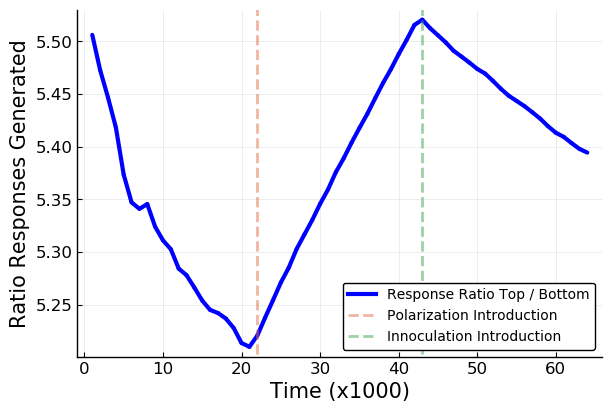

([5.66596 5.31052 … 5.71602 5.82227; 5.40377 5.57899 … 5.51275 5.70946; … ; 5.43493 5.3754 … 5.3335 5.39008; 5.4284 5.37121 … 5.33515 5.38576], [5.50623; 5.47282; … ; 5.39796; 5.39445])

In [6]:

using Random
using StatsPlots
using Plots
pyplot()

test_vector = zeros(40)

function basal_update(simulation_matrix, nodes, node, timestep, basal_rate)  
    if (rand(1)[1] <= basal_rate)
	test_vector[node] += 1
	tmp = deleteat!(collect(1:nodes), node)
        destination_n = tmp[rand(1:end)]
	simulation_matrix[node, destination_n, timestep] = 1
    end
end


function response_update_three_phase(simulation_matrix, importance, nodes, node, 
			 timesteps, timestep, response_recipients, 
			 importance_gain)

    # Loop for each node calculating response probability and performing
    # message propagation.

    mask_odd = [(-1)^x for x in 1:nodes]
    mask_even = [(-1)^(x+1) for x in 1:nodes]
    mask_odd_neutral = map(x -> rand(1)[1] > .5 ? x : 1, mask_odd)
    mask_even_neutral = map(x -> rand(1)[1] > .5 ? x : 1, mask_even)

    successful_messages_to_node = simulation_matrix[:, node, timestep-1]
    total_importance = 0

    # Check if any messages were sent
    if sum(successful_messages_to_node) > 0
	#print("Node = ", node, "\n")
	# Timesteps in phase 1
	if timestep <= timesteps/3
	    total_importance = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:nodes])
	# Timesteps in phase 2
	elseif timestep <= 2*timesteps/3
	    # Filter for odd and even group membership
	    if node % 2 == 0
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
				        mask_odd[x] for x in 1:nodes])
	    else
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
					mask_even[x] for x in 1:nodes])
	    end
	# Timesteps in phase 3
	else
	    # Filter for odd and even group membership
	    if node % 2 == 0
		
        total_importance_1 = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:Int32(floor(nodes/2))])
                
        total_importance_2 = sum([successful_messages_to_node[x] * importance[x] *
					mask_odd[x] for x in Int32(ceil(nodes/2)):nodes])
        total_importance = total_importance_1 + total_importance_2
	    
        else
		
        total_importance_1 = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:Int32(floor(nodes/2))])
                
        total_importance_2 = sum([successful_messages_to_node[x] * importance[x] *
					mask_even[x] for x in Int32(ceil(nodes/2)):nodes])
                
        total_importance = total_importance_1 + total_importance_2
        
        end
	end
    end

    # Response rate calculation
    response_numerator = total_importance
	
    response_denominator = 1 + findmax(importance)[1] * 
				sum(simulation_matrix[:, node, timestep-1])
	
    response_rate = response_numerator / response_denominator

    if total_importance != 0
	#print("Response Rate", response_rate, "\n")
    end

    # Pick response_recipients number of targets and send content with 
    # probability response_rate
    if response_rate > rand(1)[1]
	test_vector[node] += 4
	tmp = deleteat!(collect(1:nodes), node)
	destination_nodes = tmp[randperm(length(tmp))[1:response_recipients]]
	for dest_node in destination_nodes
	    simulation_matrix[node, dest_node, timestep] = 1
        end
	importance = (importance_gain * successful_messages_to_node) + importance
    else
        successful_messages_to_node = zeros(nodes,1)
    end

    return successful_messages_to_node, importance, simulation_matrix
end








function response_update_two_phase(simulation_matrix, importance, nodes, node, 
			 timesteps, timestep, response_recipients, 
			 importance_gain)

    # Loop for each node calculating response probability and performing
    # message propagation.

    mask_odd = [(-1)^x for x in 1:nodes]
    mask_even = [(-1)^(x+1) for x in 1:nodes]

    successful_messages_to_node = simulation_matrix[:, node, timestep-1]
    total_importance = 0

    # Check if any messages were sent
    if sum(successful_messages_to_node) > 0
	#print("Node = ", node, "\n")
	# Timesteps in phase 1
	if timestep <= timesteps/2
	    total_importance = sum([successful_messages_to_node[x] * importance[x] 
				    for x in 1:nodes])
	# Timesteps in phase 2
	else
	    # Filter for odd and even group membership
	    if node % 2 == 0
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
				        mask_odd[x] for x in 1:nodes])
	    else
		total_importance = sum([successful_messages_to_node[x] * importance[x] *
					mask_even[x] for x in 1:nodes])
	    end
	end
    end

    # Response rate calculation
    response_numerator = total_importance
	
    response_denominator = 1 + findmax(importance)[1] * 
				sum(simulation_matrix[:, node, timestep-1])
	
    response_rate = response_numerator / response_denominator

    if total_importance != 0
	#print("Response Rate", response_rate, "\n")
    end

    # Pick response_recipients number of targets and send content with 
    # probability response_rate
    if response_rate > rand(1)[1]
	test_vector[node] += 4
	tmp = deleteat!(collect(1:nodes), node)
	destination_nodes = tmp[randperm(length(tmp))[1:response_recipients]]
	for dest_node in destination_nodes
	    simulation_matrix[node, dest_node, timestep] = 1
        end
	importance = (importance_gain * successful_messages_to_node) + importance
    else
        successful_messages_to_node = zeros(nodes,1)
    end
    
    return successful_messages_to_node, importance, simulation_matrix
end




function capture_statistics(node, timesteps, timestep, messages_sent, 
			    responses_triggered, total_responses, three_phase)
    if three_phase
        # Gather total responses triggered grouped by phase (1,2,3)
        if timestep < timesteps/3
            responses_triggered[:, node, 1] = responses_triggered[:, node, 1] .+ 
					      messages_sent
        elseif timestep < 2*timesteps/3
            responses_triggered[:, node, 2] = responses_triggered[:, node, 2] .+
					      messages_sent
        else
            responses_triggered[:, node, 3] = responses_triggered[:, node, 3] .+
	    				      messages_sent
        end

    else
        if timestep < timesteps/2
            responses_triggered[:, node, 1] = responses_triggered[:, node, 1] .+ 
					      messages_sent
        else
            responses_triggered[:, node, 2] = responses_triggered[:, node, 2] .+
					      messages_sent
	end
    end
    # Sum responses for total_responses to gather trend over time
    if timestep % 1000 == 0
        collected_responses = responses_triggered[:,:,1] .+
			      responses_triggered[:,:,2] .+
			      responses_triggered[:,:,3]
        total_responses[:, Int32(ceil(timestep/1000))] = sum(collected_responses, dims=2)
    end
    return responses_triggered, total_responses
end




function simulation_loop(nodes=40, timesteps=24000, three_phase=false,
			 basal_rate=0.06, basal_recipients=1, 
			 response_recipients=4, importance_gain=1)
    
    # Main simulation loop that will update the state of the simulation
    # at each time step and store relevant data for visualization

    if three_phase
        response_update=response_update_three_phase
    else
        response_update=response_update_two_phase
    end

    importance = [x^3 for x in 1:nodes]
    
    responses_triggered = zeros(nodes, nodes, 3)
    total_responses = zeros(nodes, Int32(ceil(timesteps/1000)))

    # Memory Map if system memory is less than 16 GB and nodes > 100. 
    # Not Ideal - Very Slow 
    if Sys.free_memory()/2^30 < 16.00 && nodes > 100
        s = open("/tmp/juliaA", "w+")
        simulation_matrix = Mmap.mmap(s, Array{UInt8, 3}, (nodes, nodes, 
				      timesteps))
    else
	simulation_matrix = zeros(nodes, nodes, timesteps)
    end

    # Only basal for timestep = 1 because t-1 does not exist for response.
    for node in 1:nodes
        basal_update(simulation_matrix, nodes, node, 1, basal_rate)    
    end

    # Main update loop
    for timestep in 2:timesteps
	# Loop through each node every time step
        for node in 1:nodes
            # Calculate each nodes basal content
            basal_update(simulation_matrix, nodes, node, timestep, basal_rate)
            # Calculate each nodes response content
	    messages_sent, importance, simulation_matrix = response_update(simulation_matrix, 
					    importance, nodes, node, 
			      		    timesteps, timestep, 
					    response_recipients, 
			      		    importance_gain)
            # Capture stats for visualization
	    responses_triggered, total_responses = capture_statistics(node, timesteps, timestep, messages_sent, 
			       responses_triggered, total_responses, three_phase)
        end
    end
    
    group_ratio = [sum(total_responses[Int32(ceil(nodes/2+1)):nodes, i]) /
    	       sum(total_responses[1:Int32(ceil(nodes/2)), i]) 
	       for i in 1:Int32(ceil(timesteps/1000))] 
    return group_ratio, total_responses, responses_triggered
end




function main(nodes, timesteps, runs, three_phase)
    # Data structures for capturing statistics and averaging over multiple runs
    
    group_ratios = zeros(Int32(ceil(timesteps/1000)), runs)
    responses_triggered = zeros(nodes, nodes, 3, runs)
    total_responses = zeros(nodes, Int32(ceil(timesteps/1000)), runs)
    total_relative = zeros(2, Int32(ceil(nodes/2)))


    for run in 1:runs
        group_ratios[:,run], total_responses[:,:,run], 
		responses_triggered[:,:,:,run] = simulation_loop(nodes, timesteps, 
						                 three_phase)
    end

    #######################
    ### STATS GATHERING ###
    #######################
    average_ratio = sum(group_ratios, dims=2)./runs
    
    # if runs=1, the same as responses triggered
    average_triggered = sum(responses_triggered, dims=4)./runs
    

    # how many times a node is triggered in phase 1 (pre-polarization)
    responses_per_node = sum(average_triggered[:,:,1], dims=1)

    j = 1
    for i in 1:2:nodes
	total_relative[1, j] = responses_per_node[i]
	total_relative[2, j] = responses_per_node[i+1]
	j += 1
    end

    ################
    ### PLOTTING ###
    ################

    names = [string(x," ",x+1) for x in 1:nodes]
    groupedbar(names, total_relative, group=["Odd", "Even"],
	       ylabel="Messages Sent", title="Messages Sent Relative to Node 1")

    # Heatmap plots for each of the three phases of the simulation
    p = plot(average_triggered[:,:,1], seriestype=:heatmap, title="Phase1")
#     plot(p)
    savefig(p, "heatmap_phase_1.svg")
    p = plot(average_triggered[:,:,2], seriestype=:heatmap, title="Phase2")
#     plot(p)
    savefig(p, "heatmap_phase_2.svg")
    if three_phase
        p = plot(average_triggered[:,:,3], seriestype=:heatmap, title="Phase3")
#         plot(p)
        savefig(p, "heatmap_phase_3.svg")
    end
    
    p = plot(average_ratio, line=(3, :solid, [:blue, :blue, :blue]),
	     legendfontsize=10, xaxis="Time (x1000)", yaxis="Ratio Responses Generated", guidefontsize=15, tickfontsize=12,
	     label="Response Ratio Top / Bottom")
    if three_phase
        vline!([Int32(ceil(timesteps/3000))], line=(2, :dash, 0.5),
	        label="Polarization Introduction")

        vline!([Int32(ceil(2*timesteps/3000))], line=(2, :dash, 0.5),
	        label="Innoculation Introduction")
#         plot(p)
        savefig(p, "timeseries_three_phase.svg")    
    else
        vline!([Int32(ceil(timesteps/2000))], line=(2, :dash, 0.5),
		label="Polarization Introduction")
#         plot(p)
        savefig(p, "timeseries_two_phase.svg")
    end
    #sbr
    return group_ratios, average_ratio
end

group_ratios, average_ratio = main(40, 64000, 10, true)